In [1]:
from transformers import pipeline
import torch
from transformers import AutoModel, AutoTokenizer, AutoModelForCausalLM
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import ipywidgets as widgets
from IPython.display import display
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
#model = AutoModel.from_pretrained( "gpt2", output_hidden_states=True)  #load pretrained from Hugging Face
model = AutoModelForCausalLM.from_pretrained("gpt2", output_attentions=True, output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained("gpt2")                     #trasforma input in token

c:\Users\angel\Desktop\LCP_B_GPT2\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(
c:\Users\angel\Desktop\LCP_B_GPT2\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


# (Later) Testing the generative behaviour with different prompts

### Short Prompts (1–5 words)
Good for analyzing minimal context and word-level embeddings.

- "Sunset"

- "The quick fox"

- "Hello world"

- "Once upon a"

- "Artificial intelligence"

### Medium Prompts (6–15 words)
Useful for observing basic syntactic and semantic patterns.

- "The cat sat on the warm windowsill and purred quietly."

- "He opened the door to find a mysterious package waiting."

- "Deep learning has revolutionized computer vision and natural language processing."

- "A sudden noise startled her while she was reading a book."

- "The recipe called for eggs, flour, sugar, and a pinch of salt."

### Long Prompts (16–50 words)
Better for studying how GPT-2 processes extended context or narrative flow.

- "The scientist carefully adjusted the settings on the control panel, knowing that one wrong move could trigger a catastrophic failure that would destroy years of research and potentially endanger lives."

- "In a future where machines have gained consciousness, a lone programmer works tirelessly to insert a backdoor into the system, hoping to reclaim control of a world slipping away."

- "During the final debate, the candidate made a passionate appeal to unity, addressing both critics and supporters, promising transparency, economic reform, and a renewed focus on international cooperation."

### Very Long Prompt (50+ words)
Use this to test GPT-2’s capacity limits, token truncation, and how it handles deeper coherence.

- "As the storm raged outside, Maria sat by the fireplace, recalling the last letter her brother had sent before disappearing in the mountains. It spoke of a hidden temple, an ancient curse, and a secret he had vowed to protect at all costs. Her hands trembled as she read it again."

(Prompt with dialogue and descriptive elements)
- "“I never asked for this,” he whispered, staring at the broken mask in his hands. Around him, the ruins of the facility burned, casting eerie shadows on the bloodstained walls. Footsteps echoed in the corridor—someone was still alive. And they were looking for him."

In [3]:
prompts = {
    "short": [
        "Sunset",
        "The quick fox",
        "Hello world",
        "Once upon a",
        "Artificial intelligence"
    ],
    "medium": [
        "The cat sat on the warm windowsill and purred quietly.",
        "He opened the door to find a mysterious package waiting.",
        "Deep learning has revolutionized computer vision and natural language processing.",
        "A sudden noise startled her while she was reading a book.",
        "The recipe called for eggs, flour, sugar, and a pinch of salt."
    ],
    "long": [
        "The scientist carefully adjusted the settings on the control panel, knowing that one wrong move could trigger a catastrophic failure that would destroy years of research and potentially endanger lives.",
        "In a future where machines have gained consciousness, a lone programmer works tirelessly to insert a backdoor into the system, hoping to reclaim control of a world slipping away.",
        "During the final debate, the candidate made a passionate appeal to unity, addressing both critics and supporters, promising transparency, economic reform, and a renewed focus on international cooperation."
    ],
    "very_long": [
        "As the storm raged outside, Maria sat by the fireplace, recalling the last letter her brother had sent before disappearing in the mountains. It spoke of a hidden temple, an ancient curse, and a secret he had vowed to protect at all costs. Her hands trembled as she read it again.",
        "“I never asked for this,” he whispered, staring at the broken mask in his hands. Around him, the ruins of the facility burned, casting eerie shadows on the bloodstained walls. Footsteps echoed in the corridor—someone was still alive. And they were looking for him."
    ],
    "closed": [
    "Water freezes at 0 degrees",
    "The author of Romeo and Juliet is", 
    "Einstein is best known for the theory of",
    "Brazil's official language is",
    "Jupiter is the largest",
    "Gold’s chemical symbol is",
    "Opposite in meaning to 'hot' is",
    "Where is the Great Wall located?",
    "Tokyo is the capital of",
    "A triangle has how many sides?",
    "The boiling point of water in Celsius is",
    "Who painted the Mona Lisa?",
    "Pi is approximately equal to",
    "Mount Everest is located in which country?"
    ]
}

target_answers = {
    "Water freezes at 0 degrees": "Celsius",
    "The author of Romeo and Juliet is": "Shakespeare",
    "Einstein is best known for the theory of": "relativity",
    "Brazil's official language is": "Portuguese",
    "Jupiter is the largest": "planet",
    "Gold’s chemical symbol is": "Au",
    "Opposite in meaning to 'hot' is": "cold",
    "Where is the Great Wall located?": "China",
    "Tokyo is the capital of": "Japan",
    "A triangle has how many sides?": "3",
    "The boiling point of water in Celsius is": "100",
    "Who painted the Mona Lisa?": "Leonardo",
    "Pi is approximately equal to": "3.14",
    "Mount Everest is located in which country?": "Nepal"
}

# TO USE:
# for category, prompt_list in prompts.items():
#    for prompt in prompt_list:
#        inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)
#        outputs = model(**inputs)
#        # your embedding analysis here...


## Testing the prediction on next token

With a set of closed prompts each designed to have a specific, factual answer

In [4]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [5]:
prompt = prompts["closed"][2]
inputs = tokenizer(prompt, return_tensors="pt")
input_ids = inputs["input_ids"]
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

print("Tokens:")
for idx, tok in enumerate(tokens):
    print(f"{idx:2}: {tok}")

# Containers for attention and FFNN outputs
attention_outputs = []
mlp_outputs = []
ln1_outputs = []
ln2_outputs = []

# Hook functions to capture intermediate activations
def get_attention_output(module, input, output):
    attention_outputs.append(output[0].detach())

def get_mlp_output(module, input, output):
    mlp_outputs.append(output.detach())

def get_ln1_output(module, input, output):
    ln1_outputs.append(output.detach())

def get_ln2_output(module, input, output):
    ln2_outputs.append(output.detach())


# Register forward hooks
for block in model.transformer.h:
    block.ln_1.register_forward_hook(get_ln1_output)
    block.attn.register_forward_hook(get_attention_output)
    block.ln_2.register_forward_hook(get_ln2_output)
    block.mlp.register_forward_hook(get_mlp_output)

model.transformer.ln_f.register_forward_hook(get_ln1_output)

Tokens:
 0: E
 1: instein
 2: Ġis
 3: Ġbest
 4: Ġknown
 5: Ġfor
 6: Ġthe
 7: Ġtheory
 8: Ġof


In [6]:
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits  # Shape: [1, seq_len, vocab_size]
attentions = outputs.attentions  # List of [1, n_heads, seq_len, seq_len]


`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


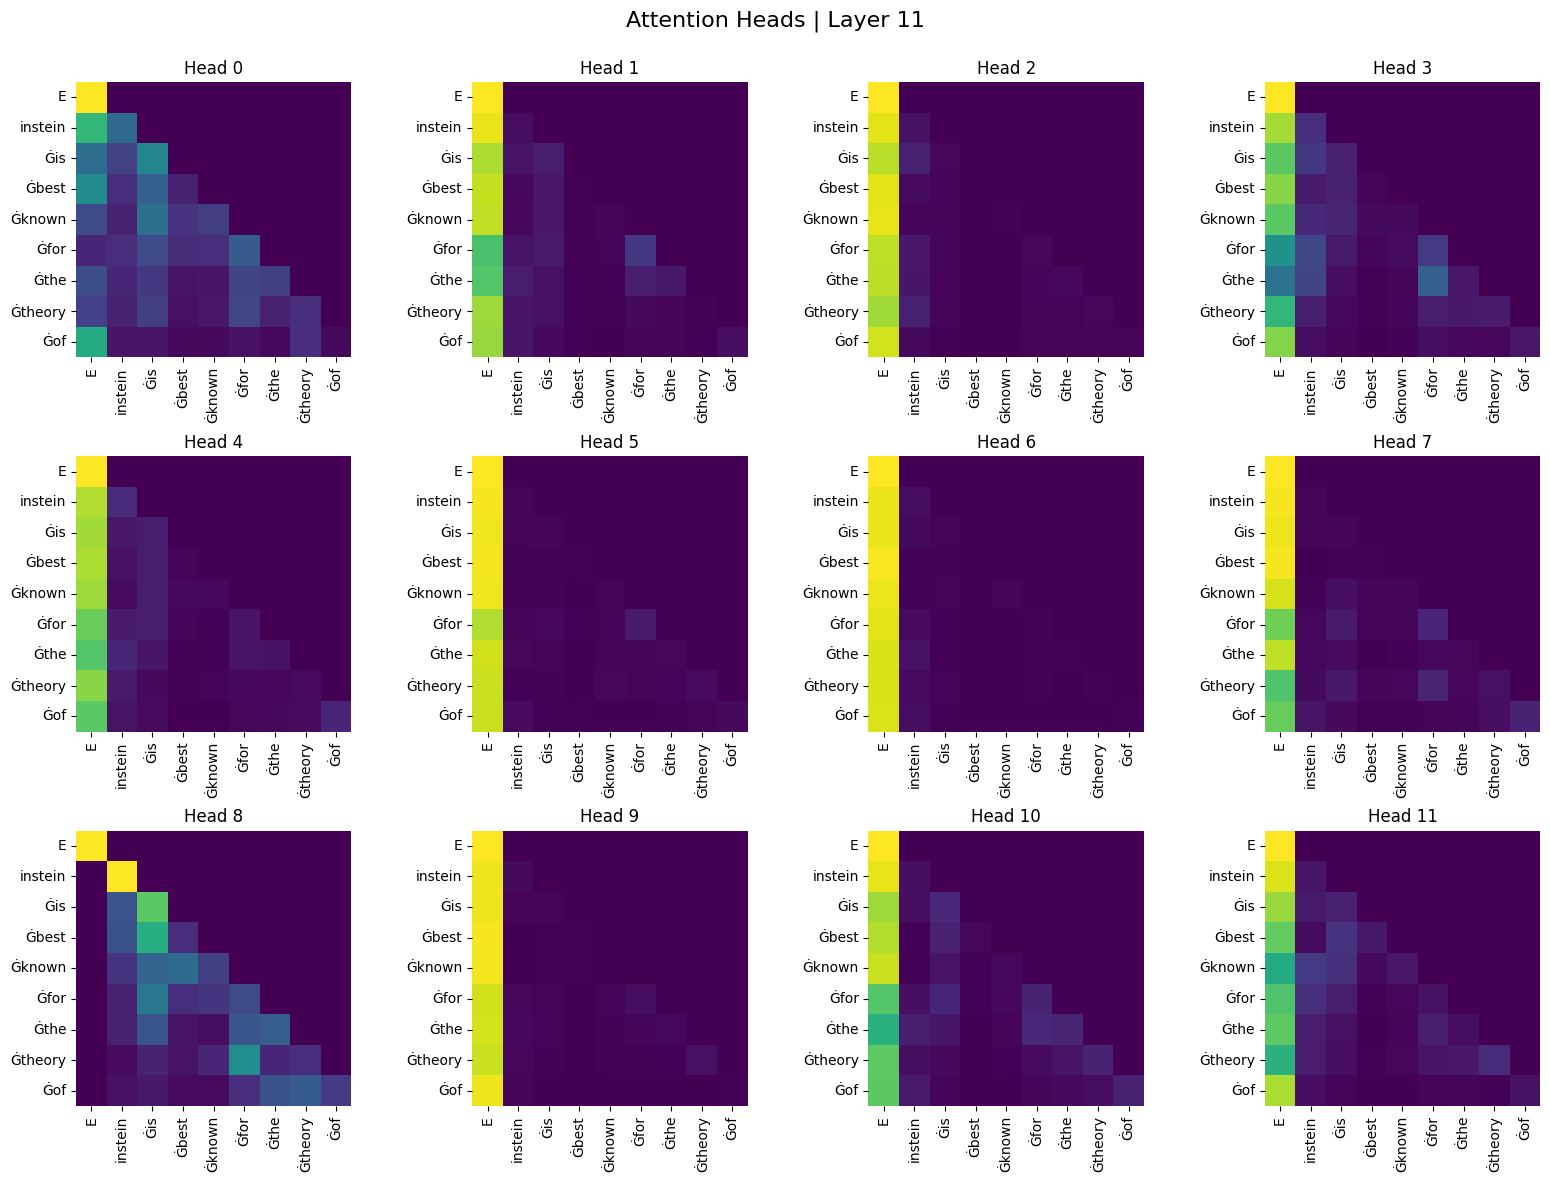

In [7]:
def plot_all_heads_last_layer(att_matrix, tokens):
    last_layer = len(att_matrix) - 1
    num_heads = att_matrix[last_layer].shape[1]
    seq_len = len(tokens)

    cols = 4
    rows = (num_heads + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    fig.suptitle(f"Attention Heads | Layer {last_layer}", fontsize=16)

    for head in range(num_heads):
        row, col = divmod(head, cols)
        ax = axes[row][col] if rows > 1 else axes[col]
        attn = att_matrix[last_layer][0, head].detach().numpy()
        sns.heatmap(attn, xticklabels=tokens, yticklabels=tokens, cmap="viridis", square=True, cbar=False, ax=ax)
        ax.set_title(f"Head {head}")
        ax.tick_params(axis='x', rotation=90)
        ax.tick_params(axis='y', rotation=0)

    # Hide unused subplots
    for idx in range(num_heads, rows * cols):
        row, col = divmod(idx, cols)
        ax = axes[row][col] if rows > 1 else axes[col]
        ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

# Call function
plot_all_heads_last_layer(attentions, tokens)

## See most probable next token, entropy and attention at each layer

Prompt: Einstein is best known for the theory of

[Attention] Layer  0: Last Token Entropy 1.2889, Mean Entropy 2.5539
   1:       Ġthe (0.8244)
   2:         Ġ" (0.1034)
   3:         Ġa (0.0194)
   4:         Ġ' (0.0040)
   5:         ĠD (0.0021)
   6:      Ġmore (0.0021)
   7:         ĠL (0.0016)
   8:     Ġfirst (0.0016)
   9:     Ġother (0.0016)
  10:        Ġan (0.0015)
[Attention] Layer  1: Last Token Entropy 14.4204, Mean Entropy 12.3701
   1:        ©¶æ (0.0037)
   2:  SPONSORED (0.0023)
   3:     sonian (0.0017)
   4:   catentry (0.0016)
   5:     Ġfixme (0.0015)
   6:   Streamer (0.0014)
   7: Ġpractition (0.0012)
   8: ĠFlavoring (0.0012)
   9: natureconservancy (0.0012)
  10:     soType (0.0012)
[Attention] Layer  2: Last Token Entropy 13.7618, Mean Entropy 14.3985
   1:   Ġphysics (0.0078)
   2:  Ġtheories (0.0069)
   3: Ġunfolding (0.0032)
   4: Ġconvergence (0.0031)
   5:   Ġbeliefs (0.0025)
   6:   Ġtheorem (0.0025)
   7:  Ġcalculus (0.0022)
   8: Ġphotography (0.0021)

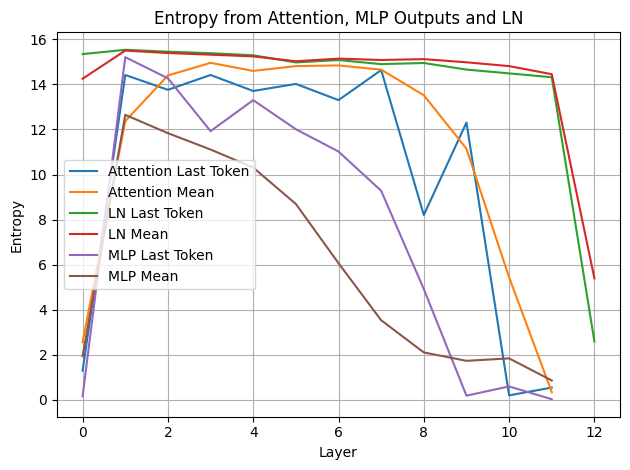

In [8]:
# Language modeling head
lm_head = model.lm_head  # Linear layer from hidden dim -> vocab size
top_k = 10  # Change as needed
token_position = -1  # Last token in prompt

print(f"Prompt: {prompt}\n")

temperature = 1.0  # Try 0.7 for sharper, or 1.5 for more diverse

def compute_entropy_from_outputs(outputs_list, label):
    entropy_last = []
    entropy_mean = []
    for i, layer_output in enumerate(outputs_list):
        hidden = layer_output  # shape: [1, seq_len, hidden_dim]
        last_token_vec = hidden[0, token_position, :]  # [hidden_dim]
        logits = lm_head(last_token_vec)
        scaled_logits = logits / temperature
        probs = torch.softmax(scaled_logits, dim=-1)
        top_probs, top_ids = torch.topk(probs, top_k)
        top_tokens = tokenizer.convert_ids_to_tokens(top_ids)
        
        entropy = -torch.sum(probs * torch.log2(probs + 1e-12)).item()
        entropy_last.append(entropy)

        all_logits = lm_head(hidden[0])  # shape: [seq_len, vocab_size]
        all_scaled_logits = all_logits / temperature
        all_probs = torch.softmax(all_scaled_logits, dim=-1)
        all_entropy = -torch.sum(all_probs * torch.log2(all_probs + 1e-12)).item()
        mean_entropy = all_entropy / all_probs.size(0)
        entropy_mean.append(mean_entropy)

        print(f"[{label}] Layer {i:2d}: Last Token Entropy {entropy:.4f}, Mean Entropy {mean_entropy:.4f}")
        for j in range(top_k):
            print(f"  {j+1:2d}: {top_tokens[j]:>10} ({top_probs[j].item():.4f})")

    
    return entropy_last, entropy_mean

# Compute for attention and MLP outputs
attn_entropy_last, attn_entropy_mean = compute_entropy_from_outputs(attention_outputs, "Attention")
mlp_entropy_last, mlp_entropy_mean = compute_entropy_from_outputs(mlp_outputs, "MLP")
ln_entropy_last, ln_entropy_mean = compute_entropy_from_outputs(ln1_outputs, "LN")

# Plotting
plt.plot(attn_entropy_last, label="Attention Last Token")
plt.plot(attn_entropy_mean, label="Attention Mean")
plt.plot(ln_entropy_last, label="LN Last Token")
plt.plot(ln_entropy_mean, label="LN Mean")
plt.plot(mlp_entropy_last, label="MLP Last Token")
plt.plot(mlp_entropy_mean, label="MLP Mean")
plt.xlabel("Layer")
plt.ylabel("Entropy")
plt.title("Entropy from Attention, MLP Outputs and LN")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


To analyze the dynamics of hidden states across layers, you're essentially exploring how the internal token representations evolve at each layer of the transformer. Here are several ways you can analyze and visualize these dynamics effectively:

1. Cosine Similarity Between Layers -> ROTATIONS OF TOKENS DURING TRANSFORMATION

Measure how the hidden representation of a specific token (e.g., the last token "William") changes across layers.
Cosine similarity is a measure of similarity between two vectors based on the angle between them—not their length. It's commonly used in natural language processing (NLP) to compare how "similar" two token embeddings or hidden states are.

Formula:
For two vectors A and B, the cosine similarity is:

cosine_similarity(𝐴,𝐵)=𝐴⋅𝐵/(∥𝐴∥∥𝐵∥)

1.0 → Vectors point in the same direction → Very similar

0.0 → Vectors are orthogonal (90° apart) → No similarity

–1.0 → Vectors point in opposite directions → Completely dissimilar
​

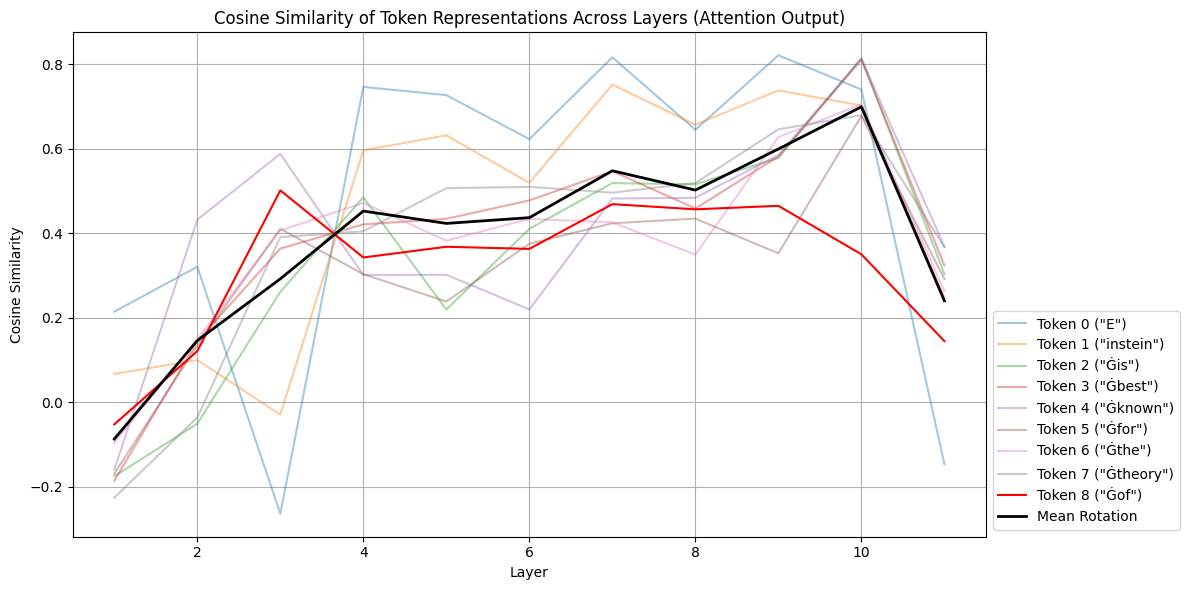

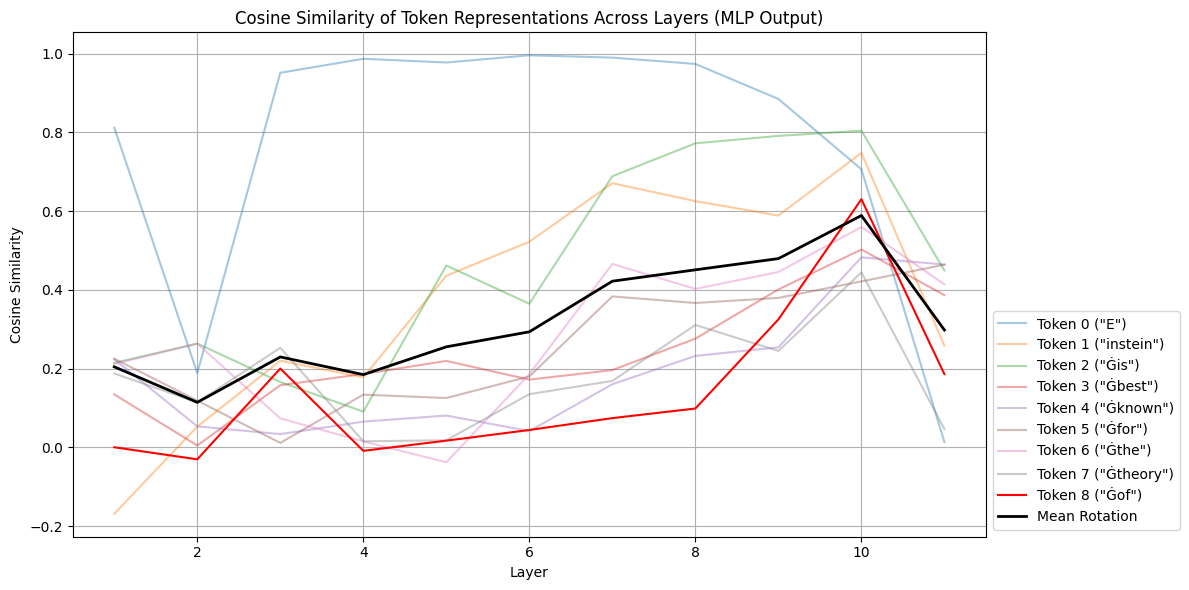

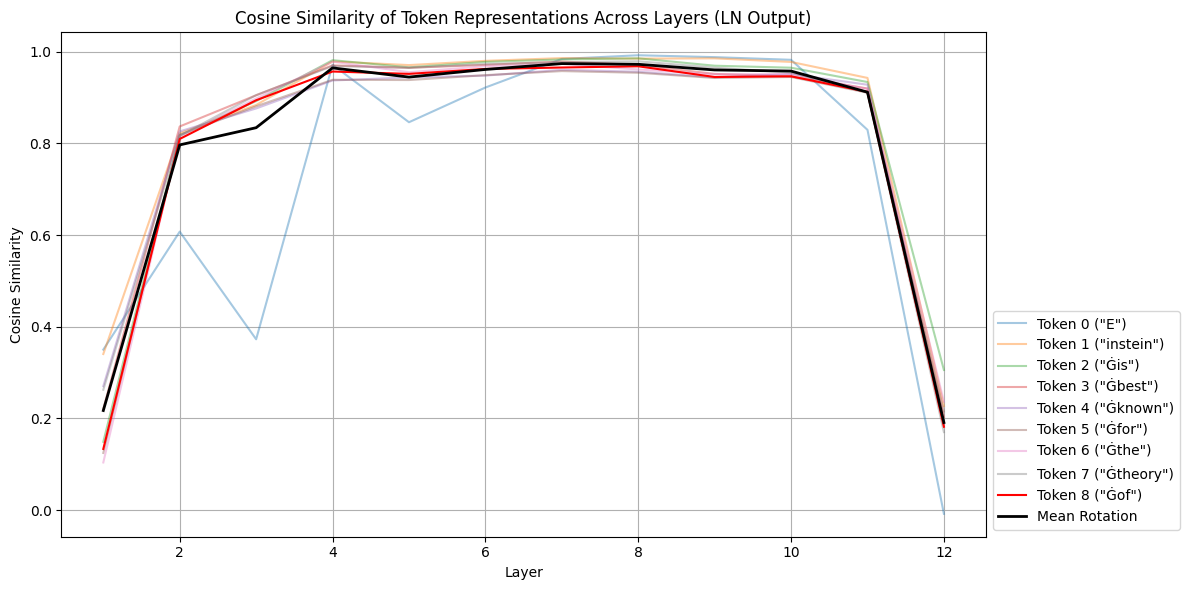

In [9]:
def compute_cosine_rotations(outputs_list, tokens, label):
    seq_len = outputs_list[0].shape[1]  # sequence length
    n_layers = len(outputs_list)
    
    all_token_rotations = []
    for pos in range(seq_len):
        vectors = [outputs_list[i][0, pos].numpy() for i in range(n_layers)]
        cos_sims = [cosine_similarity([vectors[i]], [vectors[i+1]])[0][0] for i in range(n_layers - 1)]
        all_token_rotations.append(cos_sims)

    rot_array = np.array(all_token_rotations)  # [seq_len, n_layers - 1]
    mean_rotations = np.mean(rot_array, axis=0)

    # Plot
    plt.figure(figsize=(12, 6))
    for pos in range(seq_len - 1):
        plt.plot(range(1, n_layers), rot_array[pos], label=f'Token {pos} ("{tokens[pos]}")', alpha=0.4)
    plt.plot(range(1, n_layers), rot_array[-1], label=f'Token {seq_len - 1} ("{tokens[-1]}")', color='red')
    plt.plot(range(1, n_layers), mean_rotations, label='Mean Rotation', color='black', linewidth=2)

    plt.title(f'Cosine Similarity of Token Representations Across Layers ({label})')
    plt.xlabel('Layer')
    plt.ylabel('Cosine Similarity')
    plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return rot_array, mean_rotations

# Attention and MLP outputs are already captured using hooks
attn_rot_array, attn_mean_rot = compute_cosine_rotations(attention_outputs, tokens, "Attention Output")
mlp_rot_array, mlp_mean_rot = compute_cosine_rotations(mlp_outputs, tokens, "MLP Output")
ln_rot_array, ln_mean_rot = compute_cosine_rotations(ln1_outputs, tokens, "LN Output")

1.1. Similarity measures with Target token (for closed prompts)

In [10]:
def compare_to_target_embedding(outputs_list, target_embed, token_position, token_label, target_token, label):
    n_layers = len(outputs_list)
    vectors = [outputs_list[i][0, token_position].numpy() for i in range(n_layers)]

    cos_sims = [cosine_similarity([vec], [target_embed])[0][0] for vec in vectors]
    eucl_dists = [np.linalg.norm(vec - target_embed) for vec in vectors]

    # Plot both
    plt.figure(figsize=(14, 5))

    # Cosine similarity plot
    plt.subplot(1, 2, 1)
    plt.plot(range(n_layers), cos_sims, marker='o', color='navy')
    plt.title(f'{label}: Cosine Similarity to Target "{target_token}" ({token_label})')
    plt.xlabel('Layer')
    plt.ylabel('Cosine Similarity')
    plt.grid(True)

    # Euclidean distance plot
    plt.subplot(1, 2, 2)
    plt.plot(range(n_layers), eucl_dists, marker='o', color='firebrick')
    plt.title(f'{label}: Euclidean Distance to Target "{target_token}" ({token_label})')
    plt.xlabel('Layer')
    plt.ylabel('L2 Distance')
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    
    return cos_sims, eucl_dists


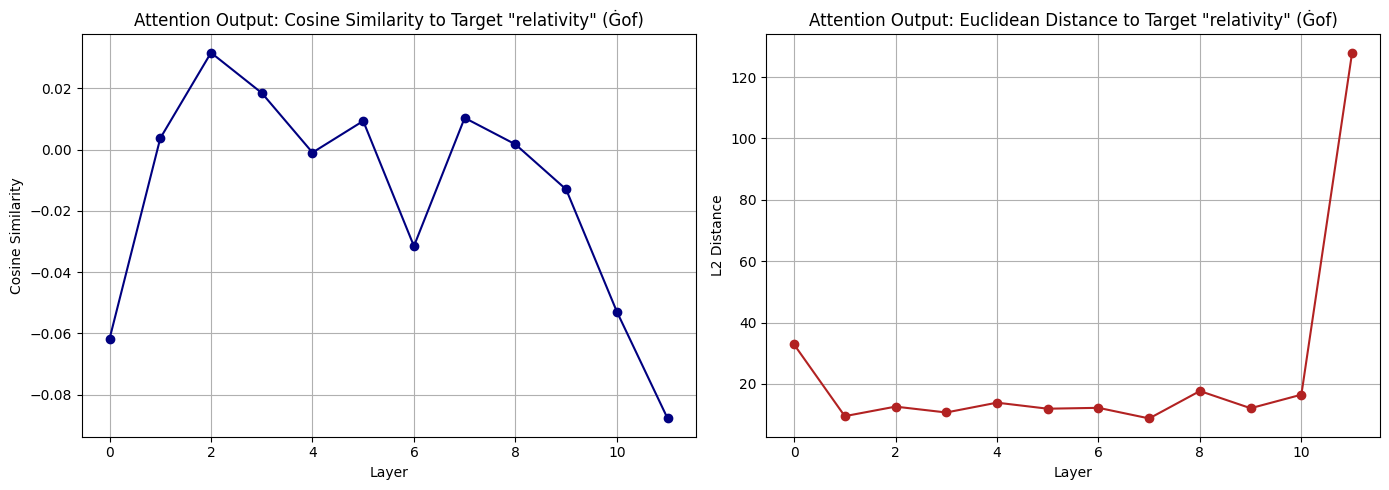

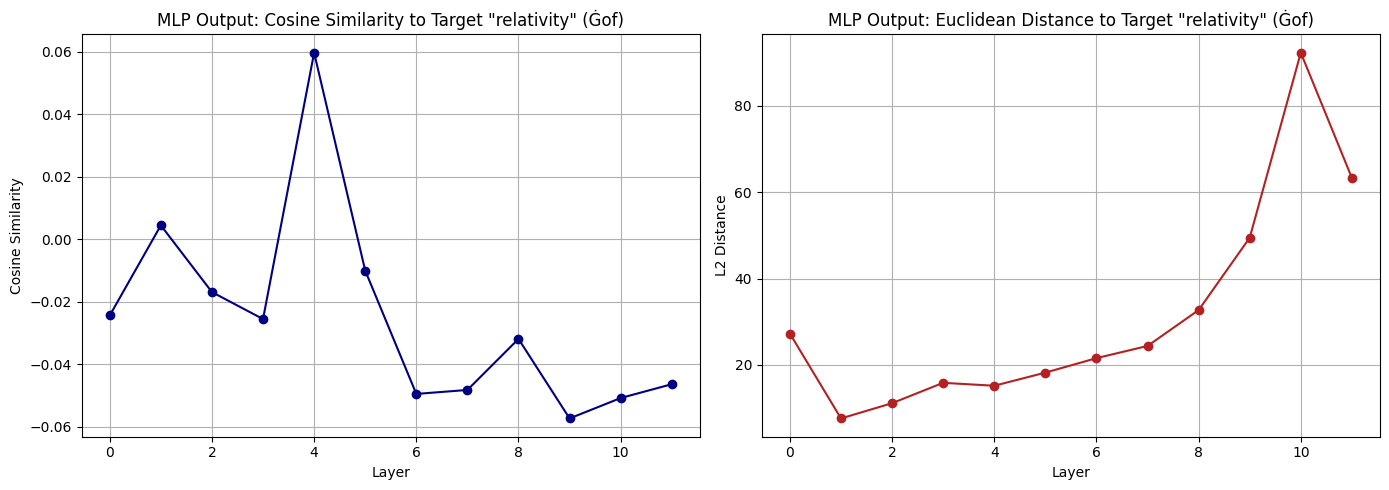

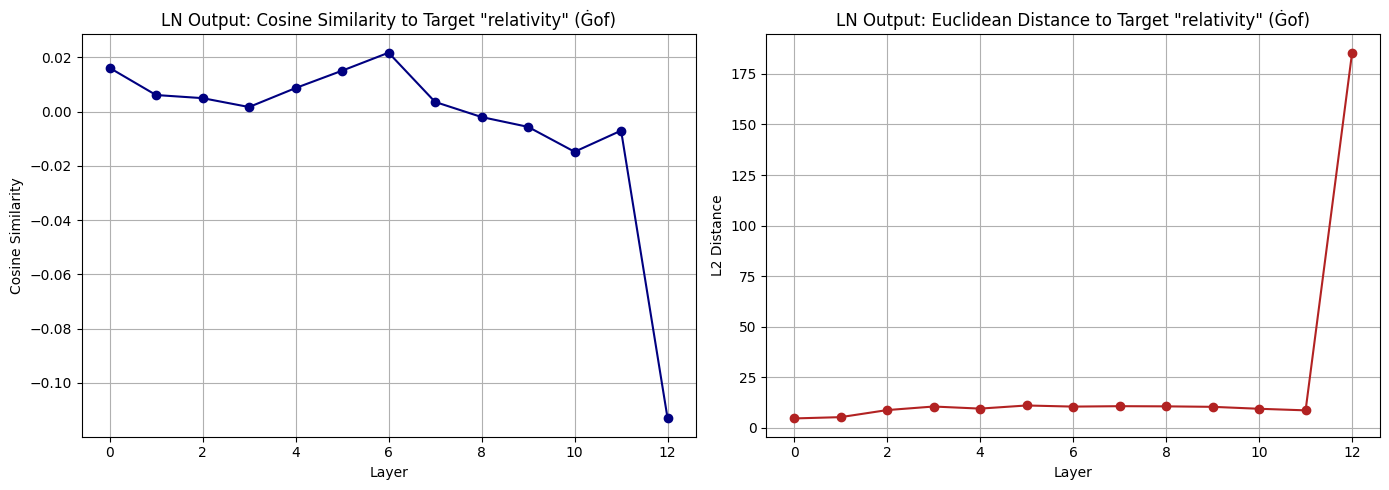

In [11]:
target_token = target_answers[prompt]
target_id = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(target_token))[0]
with torch.no_grad():
    target_embed = model.get_input_embeddings()(torch.tensor([target_id])).squeeze().numpy()

# Last token position and vectors
token_position = -1
token_label = tokens[token_position]

attn_cos, attn_dist = compare_to_target_embedding(
    attention_outputs, target_embed, token_position, token_label, target_token, "Attention Output"
)

mlp_cos, mlp_dist = compare_to_target_embedding(
    mlp_outputs, target_embed, token_position, token_label, target_token, "MLP Output"
)

ln_cos, ln_dist = compare_to_target_embedding(
    ln1_outputs, target_embed, token_position, token_label, target_token, "LN Output"
)


Interpretation:
Cosine similarity shows directional alignment — higher means more semantically aligned.

Euclidean distance shows absolute position closeness — lower means closer in space.

We try to repeat the computation with normalized vectors (so distance is no more dependent on magnitude); this often makes cosine and Euclidean inversely correlated on unit vectors (i.e., higher similarity → lower distance).

In [ ]:
def compare_multiple_targets(outputs_list, target_embeds, token_position, token_label, top_tokens, label):
    n_layers = len(outputs_list)
    cos_sims_all = []
    eucl_dists_all = []
    norm_eucl_dists_all = []

    for idx, target_embed in enumerate(target_embeds):
        cos_sims = []
        eucl_dists = []
        norm_eucl_dists = []
        for layer in range(n_layers):
            vec = outputs_list[layer][0, token_position].cpu().numpy()
            cos_sims.append(cosine_similarity([vec], [target_embed])[0][0])
            eucl_dists.append(np.linalg.norm(vec - target_embed))
            norm_diff = np.linalg.norm(vec - target_embed)
            norm_base = np.linalg.norm(target_embed)
            normalized_dist = norm_diff / (norm_base + 1e-8)  # Avoid division by zero
            norm_eucl_dists.append(normalized_dist)

        cos_sims_all.append(cos_sims)
        eucl_dists_all.append(eucl_dists)
        norm_eucl_dists_all.append(norm_eucl_dists)
        

    # Prepare colors from plasma colormap
    cmap = cm.get_cmap("plasma", len(top_tokens))
    colors = [cmap(i) for i in range(len(top_tokens))]

    # Plot Cosine Similarity
    plt.figure(figsize=(14, 5))
    for i, token in enumerate(top_tokens):
        color = 'black' if i == 0 else colors[i]
        lw = 3 if i == 0 else 1
        zorder = 3 if i == 0 else 1
        plt.plot(cos_sims_all[i], label=token.strip(), color=color, linewidth=lw, marker='o', zorder=zorder)
    plt.title(f'{label}: Cosine Similarity to 10 Top Predictions (from last token "{token_label}")')
    plt.xlabel("Layer")
    plt.ylabel("Cosine Similarity")
    plt.grid(True)
    plt.legend(fontsize='small', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Plot Euclidean Distance
    plt.figure(figsize=(14, 5))
    for i, token in enumerate(top_tokens):
        color = 'black' if i == 0 else colors[i]
        lw = 3 if i == 0 else 1
        zorder = 3 if i == 0 else 1
        plt.plot(eucl_dists_all[i], label=token.strip(), color=color, linewidth=lw, marker='o', zorder=zorder)
    plt.title(f'{label}: Euclidean Distance to 10 Top Predictions (from last token "{token_label}")')
    plt.xlabel("Layer")
    plt.ylabel("L2 Distance")
    plt.grid(True)
    plt.legend(fontsize='small', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Plot Euclidean Distance
    plt.figure(figsize=(14, 5))
    for i, token in enumerate(top_tokens):
        color = 'black' if i == 0 else colors[i]
        lw = 3 if i == 0 else 1
        zorder = 3 if i == 0 else 1
        plt.plot(norm_eucl_dists_all[i], label=token.strip(), color=color, linewidth=lw, marker='o', zorder=zorder)
    plt.title(f'{label}: Normalized Euclidean Distance to 10 Top Predictions (from last token "{token_label}")')
    plt.xlabel("Layer")
    plt.ylabel("L2 Distance")
    plt.grid(True)
    plt.legend(fontsize='small', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    return cos_sims_all, eucl_dists_all, norm_eucl_dists

token_position = -1
token_label = tokens[token_position]

# Run similarity comparison
attn_cos_all, attn_dist_all, _ = compare_multiple_targets(
    attention_outputs, top_embeddings, token_position, token_label, top_tokens, "Attention Output"
)

mlp_cos_all, mlp_dist_all, _ = compare_multiple_targets(
    mlp_outputs, top_embeddings, token_position, token_label, top_tokens, "MLP Output"
)

ln_cos_all, ln_dist_all, _ = compare_multiple_targets(
    ln1_outputs, top_embeddings, token_position, token_label, top_tokens, "LN1 Output"
)


2. Hidden State Norms

See how the magnitude (L2 norm) of token vectors changes with depth. High/low norms can indicate activation saturation or sparsity.

In this context, the L2 norm (or Euclidean norm) of a token’s hidden state vector represents the magnitude or strength of that token’s representation at a given layer.

💡 Intuitively:
A larger norm implies that the model is assigning more "energy" or importance to that token's representation at that layer.

A smaller norm means the token is relatively "suppressed" or not emphasized.

🔍 In Practice:
Early layers may have low norms, as representations are still being built.

Norms often grow in middle layers, as the model encodes more semantic meaning.

In the final layers, norms may peak for important tokens (like names, verbs, or next-token-relevant words).

🔄 Norm + Attention:
High norm and high attention → token is likely critical to model's prediction.

Norm alone doesn’t say what the token means — just that its representation is strong.

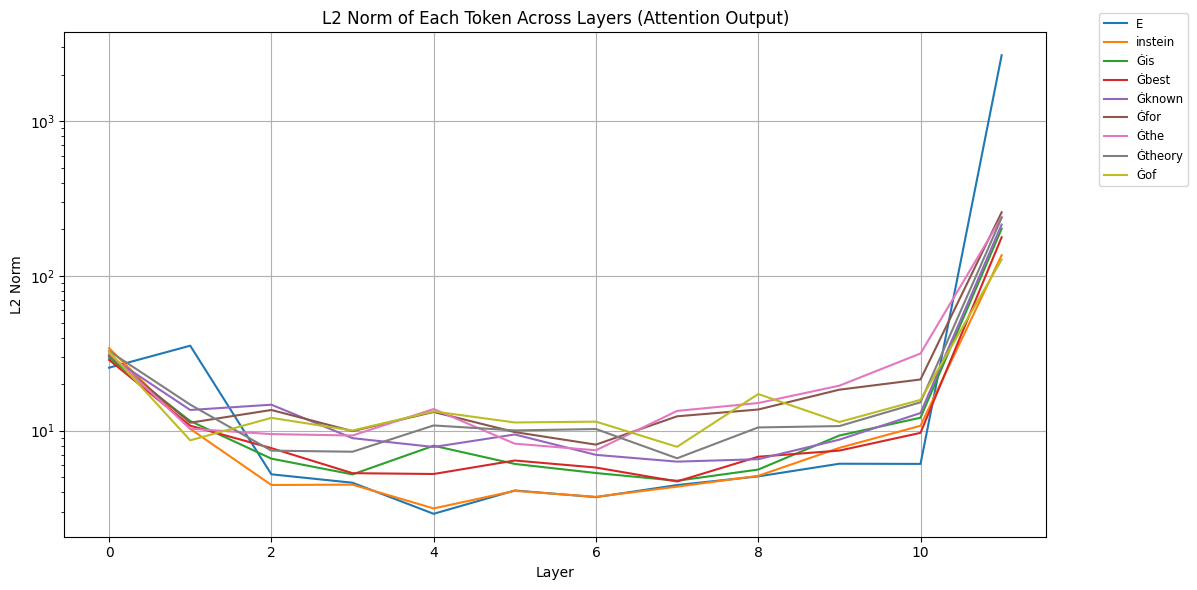

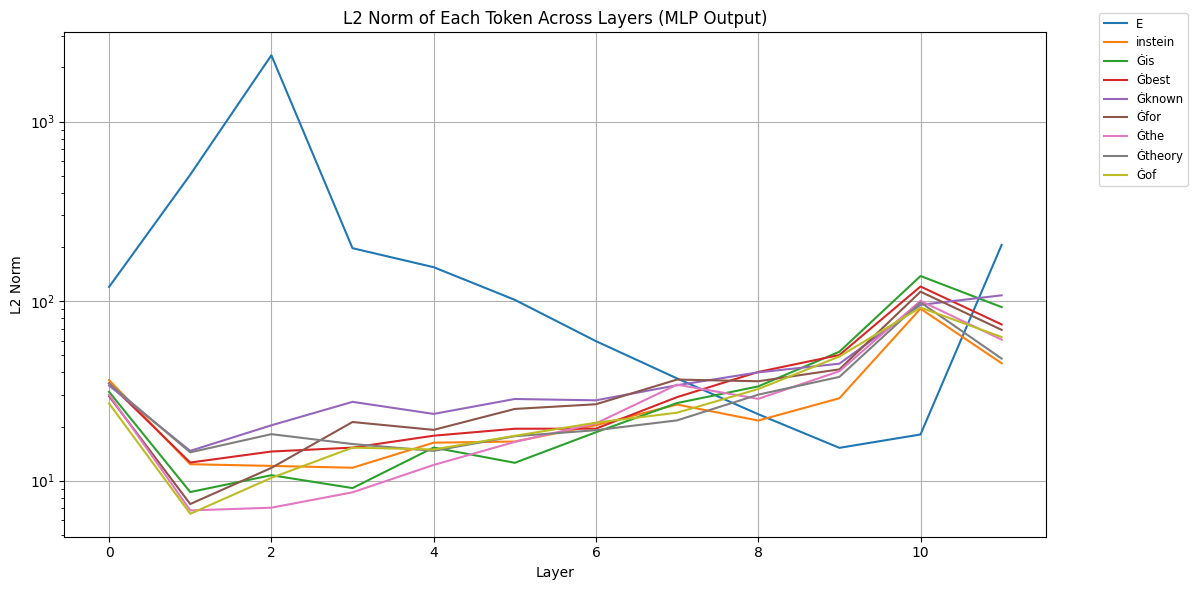

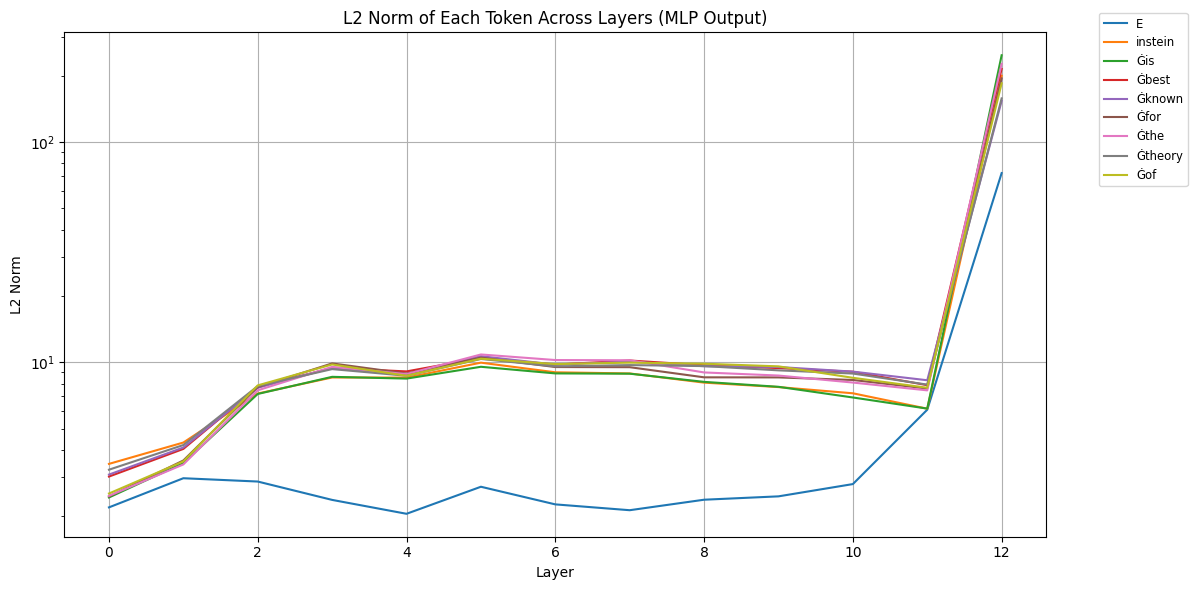

In [12]:
def plot_token_l2_norms(outputs_list, tokens, label):
    n_layers = len(outputs_list)
    seq_len = outputs_list[0].shape[1]

    plt.figure(figsize=(12, 6)) 
    for token_idx in range(seq_len):
        norms = [torch.norm(outputs_list[layer][0, token_idx]).item() for layer in range(n_layers)]
        plt.plot(range(n_layers), norms, label=tokens[token_idx])

    plt.title(f"L2 Norm of Each Token Across Layers ({label})")
    plt.xlabel("Layer")
    plt.ylabel("L2 Norm")
    plt.yscale('log')
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.05), fontsize='small', ncol=1)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_token_l2_norms(attention_outputs, tokens, "Attention Output")
plot_token_l2_norms(mlp_outputs, tokens, "MLP Output")
plot_token_l2_norms(ln1_outputs, tokens, "MLP Output")


To compute the volume of a polytope formed by token representations before and after the Feed-Forward Neural Network (FFNN) in a transformer model, you can approximate it using the square root of the determinant of the Gram matrix (a generalization of volume for vector sets in high dimensions).


✅ What You Need:
Hidden states before and after FFNN.


Construct the matrix 𝑉V using token vectors as rows.

Compute 
det(𝑉𝑉^𝑇)  — you might need regularization.

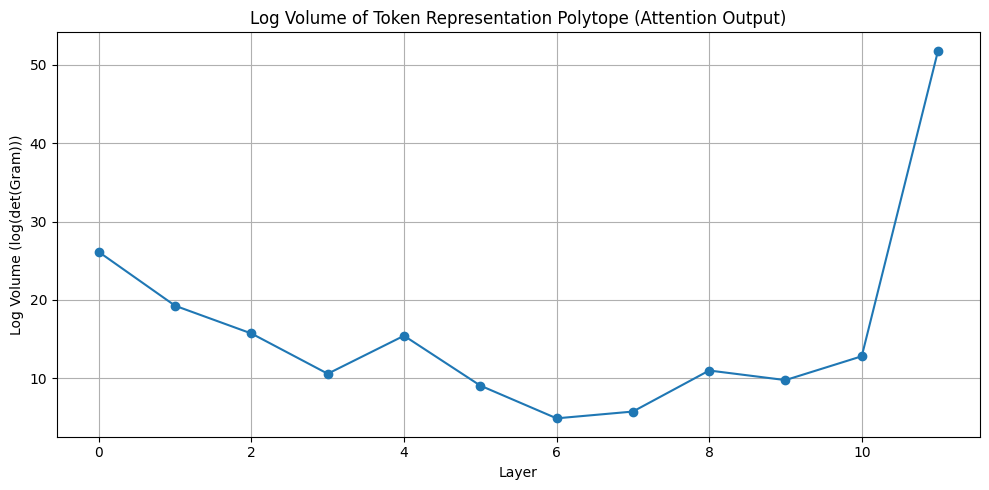

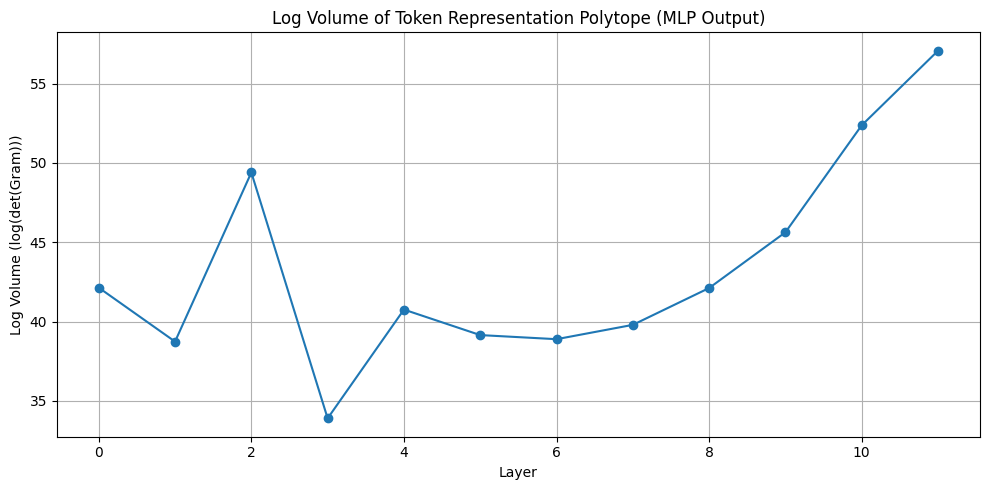

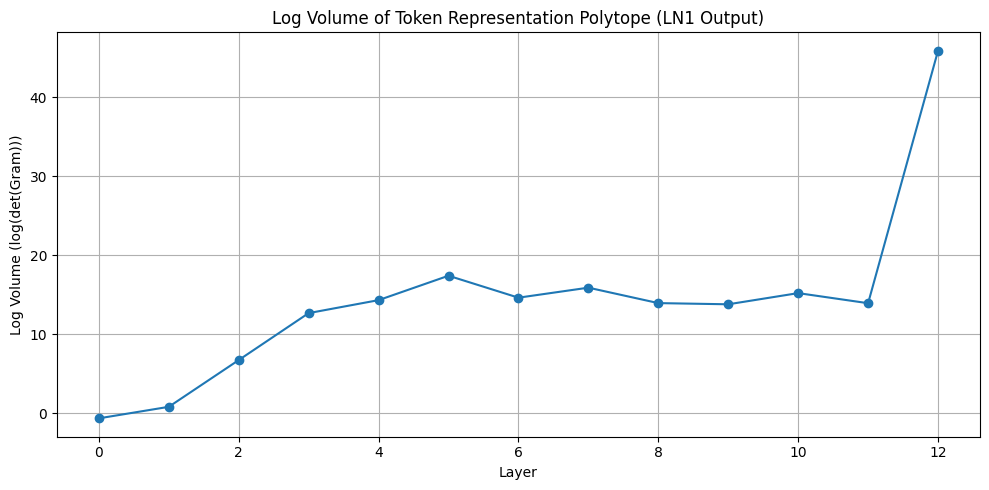

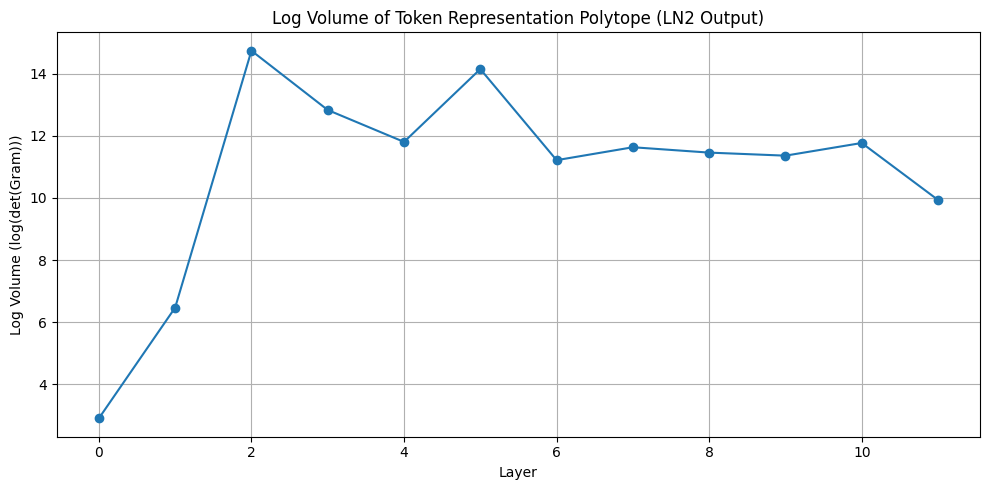

In [13]:
def compute_log_volume(outputs_list, label, epsilon=1e-6):
    log_volumes = []

    for layer_idx in range(len(outputs_list)):
        layer_vecs = outputs_list[layer_idx][0]  # shape: [seq_len, hidden_dim]

        # Center the vectors
        centered = layer_vecs - layer_vecs.mean(dim=0)
        V = centered.detach().cpu().numpy()

        # Gram matrix
        G = V @ V.T  # shape: [seq_len, seq_len]

        # Stable log-determinant of Gram
        try:
            log_det = np.linalg.slogdet(G + epsilon * np.eye(G.shape[0]))[1]
        except np.linalg.LinAlgError:
            log_det = float('-inf')

        log_volumes.append(log_det)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(outputs_list)), log_volumes, marker='o')
    plt.title(f"Log Volume of Token Representation Polytope ({label})")
    plt.xlabel("Layer")
    plt.ylabel("Log Volume (log(det(Gram)))")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return log_volumes


attn_log_vols = compute_log_volume(attention_outputs, "Attention Output")
mlp_log_vols = compute_log_volume(mlp_outputs, "MLP Output")
ln1_log_vols = compute_log_volume(ln1_outputs, "LN1 Output")
ln2_log_vols = compute_log_volume(ln2_outputs, "LN2 Output")


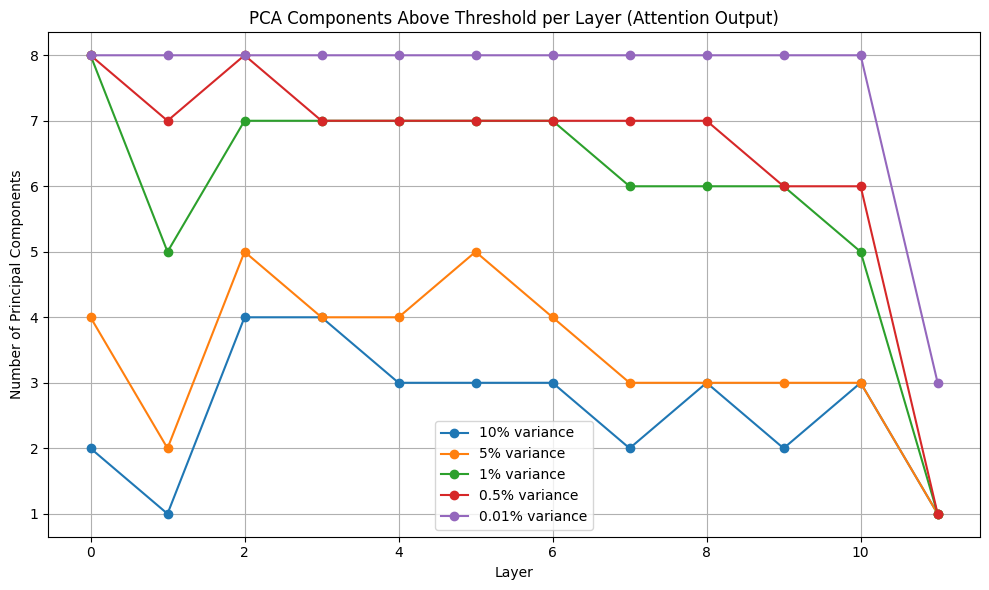

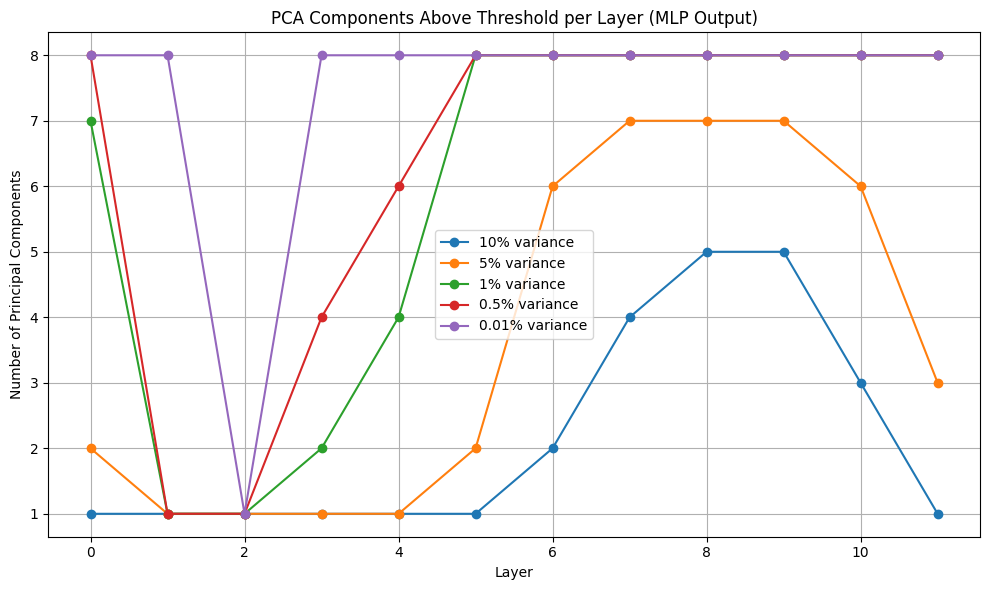

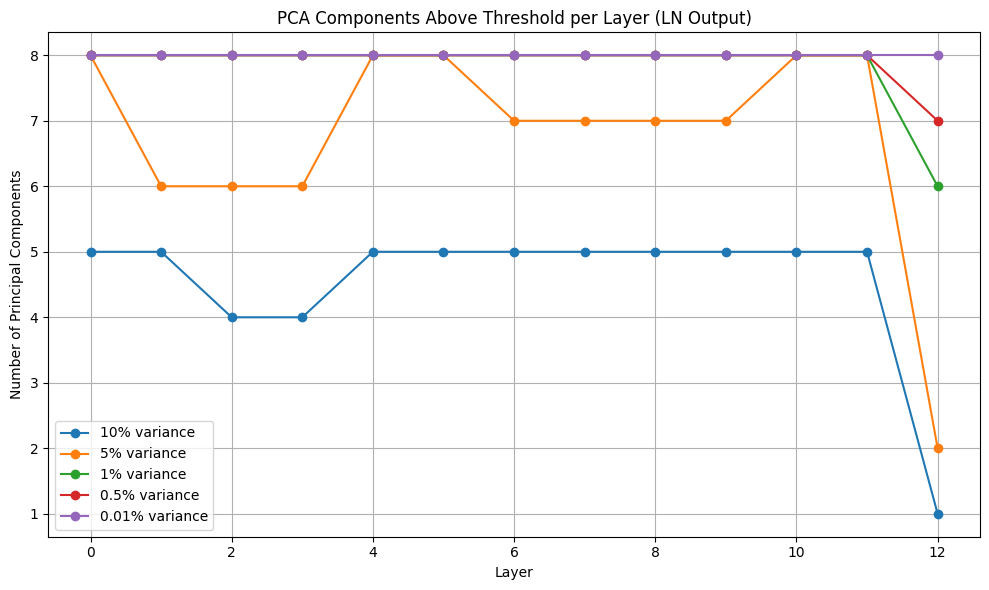

{0.1: [np.int64(5),
  np.int64(5),
  np.int64(4),
  np.int64(4),
  np.int64(5),
  np.int64(5),
  np.int64(5),
  np.int64(5),
  np.int64(5),
  np.int64(5),
  np.int64(5),
  np.int64(5),
  np.int64(1)],
 0.05: [np.int64(8),
  np.int64(6),
  np.int64(6),
  np.int64(6),
  np.int64(8),
  np.int64(8),
  np.int64(7),
  np.int64(7),
  np.int64(7),
  np.int64(7),
  np.int64(8),
  np.int64(8),
  np.int64(2)],
 0.01: [np.int64(8),
  np.int64(8),
  np.int64(8),
  np.int64(8),
  np.int64(8),
  np.int64(8),
  np.int64(8),
  np.int64(8),
  np.int64(8),
  np.int64(8),
  np.int64(8),
  np.int64(8),
  np.int64(6)],
 0.005: [np.int64(8),
  np.int64(8),
  np.int64(8),
  np.int64(8),
  np.int64(8),
  np.int64(8),
  np.int64(8),
  np.int64(8),
  np.int64(8),
  np.int64(8),
  np.int64(8),
  np.int64(8),
  np.int64(7)],
 0.0001: [np.int64(8),
  np.int64(8),
  np.int64(8),
  np.int64(8),
  np.int64(8),
  np.int64(8),
  np.int64(8),
  np.int64(8),
  np.int64(8),
  np.int64(8),
  np.int64(8),
  np.int64(8),
  np

In [14]:
def plot_pca_components(outputs_list, label, thresholds=[0.1, 0.05, 0.01, 0.005, 0.0001], threshold_labels=["10%","5%", "1%", "0.5%","0.01%"]):

    n_layers = len(outputs_list)
    layerwise_counts = {thr: [] for thr in thresholds}

    for i in range(n_layers):
        layer_representations = outputs_list[i][0].numpy()  # shape: [seq_len, hidden_dim]
        pca = PCA()
        pca.fit(layer_representations)
        explained = pca.explained_variance_ratio_

        for thr in thresholds:
            count = np.sum(explained > thr)
            layerwise_counts[thr].append(count)

    # Plot
    plt.figure(figsize=(10, 6))
    for thr, label_str in zip(thresholds, threshold_labels):
        plt.plot(range(n_layers), layerwise_counts[thr], marker='o', label=f'{label_str} variance')

    plt.title(f"PCA Components Above Threshold per Layer ({label})")
    plt.xlabel("Layer")
    plt.ylabel("Number of Principal Components")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return layerwise_counts

plot_pca_components(attention_outputs, label="Attention Output")
plot_pca_components(mlp_outputs, label="MLP Output")
plot_pca_components(ln1_outputs, label="LN Output")

3. Dimensionality Projection (e.g., PCA or t-SNE)

You can visualize the full trajectory of a token in reduced space.


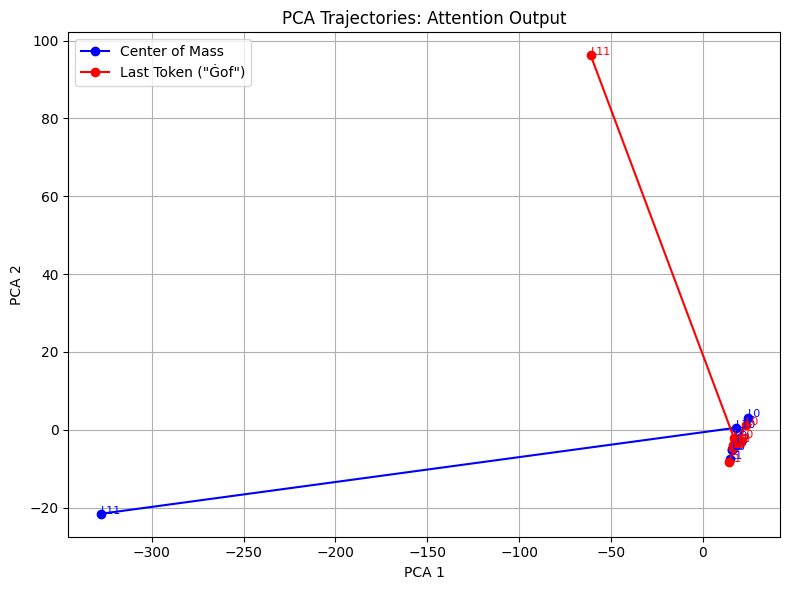

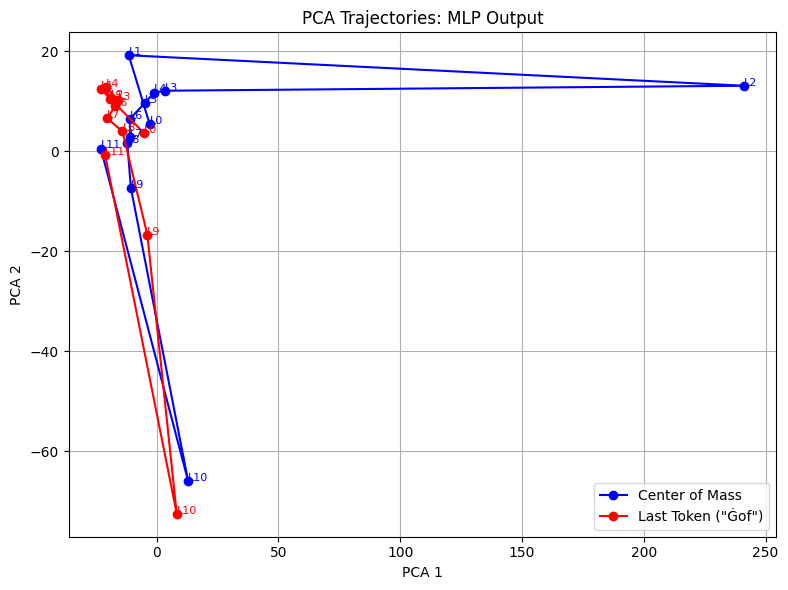

In [15]:
def plot_pca_trajectories(outputs_list, label, tokens):
    n_layers = len(outputs_list)

    # 1. Collect vectors
    last_token_vecs = [outputs_list[i][0, -1].numpy() for i in range(n_layers)]
    com_vecs = [np.mean(outputs_list[i][0].numpy(), axis=0) for i in range(n_layers)]

    # 2. Stack and perform joint PCA
    combined_vecs = np.stack(com_vecs + last_token_vecs)
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(combined_vecs)

    reduced_com = reduced[:n_layers]
    reduced_last = reduced[n_layers:]

    # 3. Plot
    plt.figure(figsize=(8, 6))
    x_com, y_com = zip(*reduced_com)
    x_last, y_last = zip(*reduced_last)

    plt.plot(x_com, y_com, marker='o', label='Center of Mass', color='blue')
    for i, (x, y) in enumerate(reduced_com):
        plt.text(x + 0.01, y + 0.01, f'L{i}', fontsize=8, color='blue')

    plt.plot(x_last, y_last, marker='o', label=f'Last Token ("{tokens[-1]}")', color='red')
    for i, (x, y) in enumerate(reduced_last):
        plt.text(x + 0.01, y + 0.01, f'L{i}', fontsize=8, color='red')

    plt.title(f"PCA Trajectories: {label}")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_pca_trajectories(attention_outputs, "Attention Output", tokens)
plot_pca_trajectories(mlp_outputs, "MLP Output", tokens)


5. Mean/Variance of All Tokens

See whether the model tends to compress or expand representations globally:

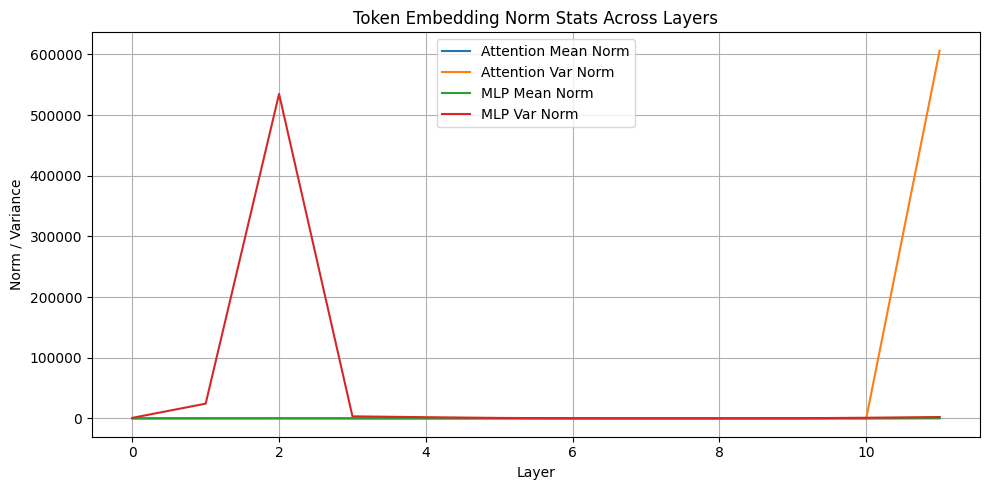

In [16]:
def plot_norm_statistics(outputs_list, label):
    all_norms = [
        torch.norm(outputs_list[i][0], dim=-1).numpy()  # shape: [seq_len]
        for i in range(len(outputs_list))
    ]
    mean_norms = [np.mean(layer_norms) for layer_norms in all_norms]
    var_norms = [np.var(layer_norms) for layer_norms in all_norms]

    plt.plot(mean_norms, label=f'{label} Mean Norm')
    plt.plot(var_norms, label=f'{label} Var Norm')
    
plt.figure(figsize=(10, 5))
plot_norm_statistics(attention_outputs, "Attention")
plot_norm_statistics(mlp_outputs, "MLP")
plt.title('Token Embedding Norm Stats Across Layers')
plt.xlabel('Layer')
plt.ylabel('Norm / Variance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


4. Compare Multiple Tokens

If you're curious about token interaction (like "William" and "Shakespeare"), you can track their relative positions over layers.

In [17]:
# Choose tokens you want to track
target_token = target_answers[prompt]
target_id = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(target_token))[0]
with torch.no_grad():
    target_embed = model.get_input_embeddings()(torch.tensor([target_id])).squeeze().numpy()


target_tokens = ["Romeo", "Juliet", "William", "Shakespeare"]  # Add "Shakespeare" to target tokens
token_indices = [i for i, tok in enumerate(tokens) if any(t in tok for t in target_tokens)]
tracked_tokens = [tokens[i] for i in token_indices]

print("Tracking tokens at positions:", list(zip(tracked_tokens, token_indices)))

# Collect token trajectories
token_trajectories = {tok: [] for tok in tracked_tokens}

for i in range(n_layers):
    for tok, idx in zip(tracked_tokens, token_indices):
        vec = hidden_states[i][0, idx].numpy()
        token_trajectories[tok].append(vec)

# Combine all vectors to fit PCA
all_vecs = np.concatenate([token_trajectories[tok] for tok in tracked_tokens], axis=0)
pca = PCA(n_components=2)
all_reduced = pca.fit_transform(all_vecs)

# Split back into token trajectories
offset = 0
token_reduced = {}
for tok in tracked_tokens:
    token_reduced[tok] = all_reduced[offset:offset + n_layers]
    offset += n_layers

# Plot
plt.figure(figsize=(10, 7))
colors = ['red', 'green', 'blue', 'orange']  # Added color for "Shakespeare"

for tok, col in zip(tracked_tokens, colors):
    coords = token_reduced[tok]
    x, y = zip(*coords)
    plt.plot(x, y, marker='o', label=tok, color=col)
    for i, (px, py) in enumerate(coords):
        plt.text(px + 0.01, py + 0.01, f'L{i}', fontsize=8, color=col)

plt.title("PCA Trajectories of Selected Tokens Across Layers")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend()
plt.grid(True)
plt.show()


Tracking tokens at positions: []


NameError: name 'n_layers' is not defined

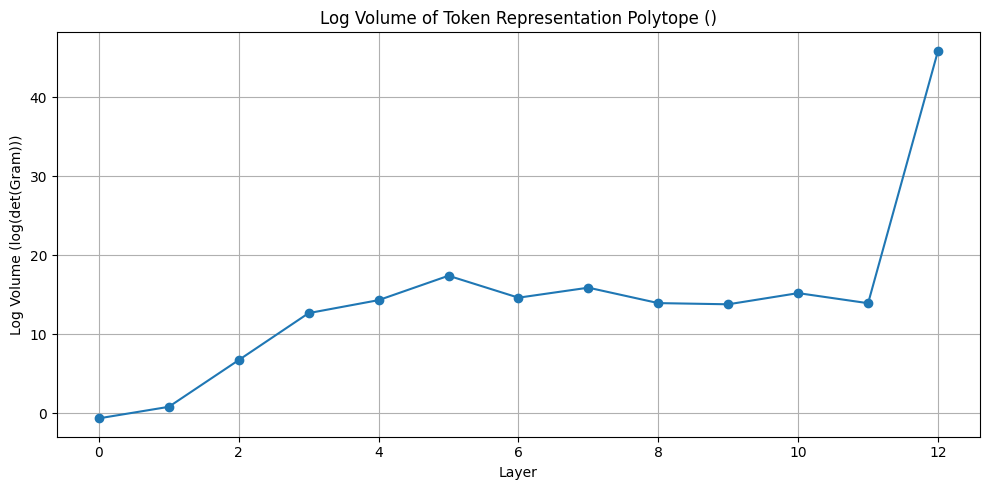

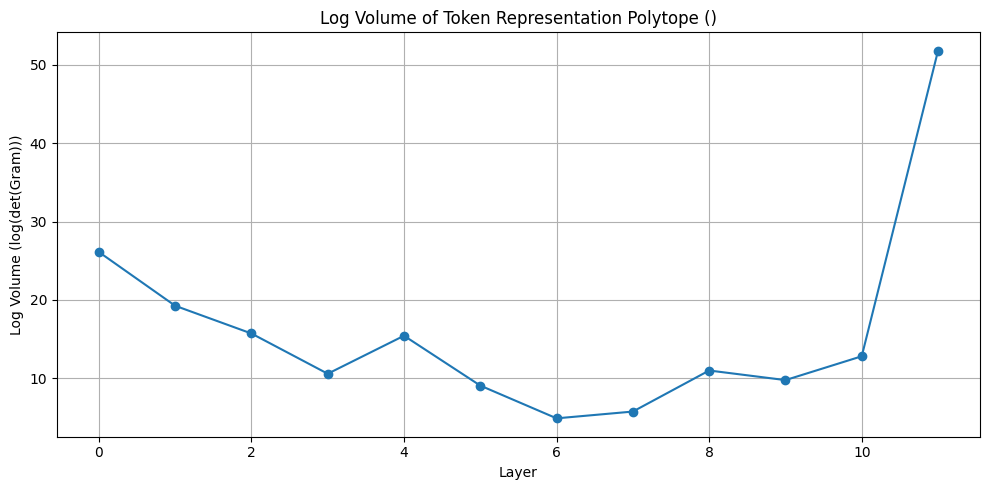

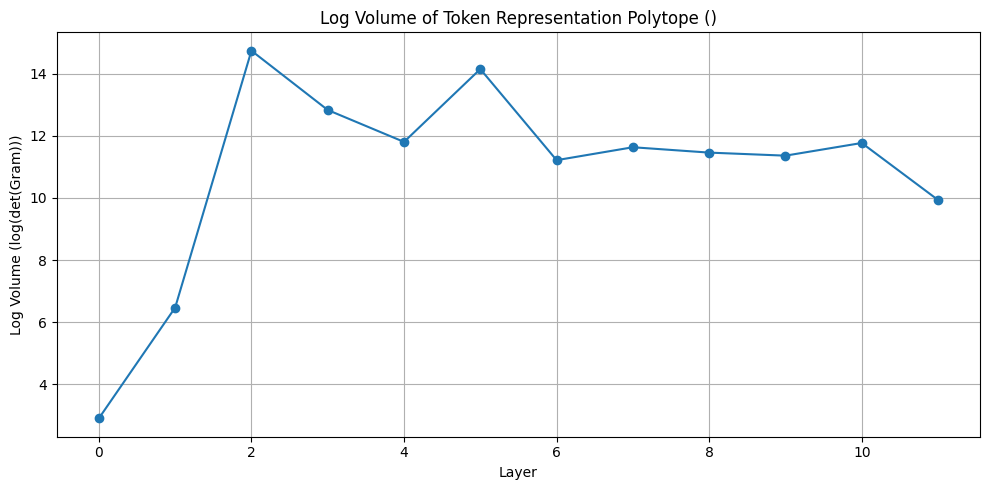

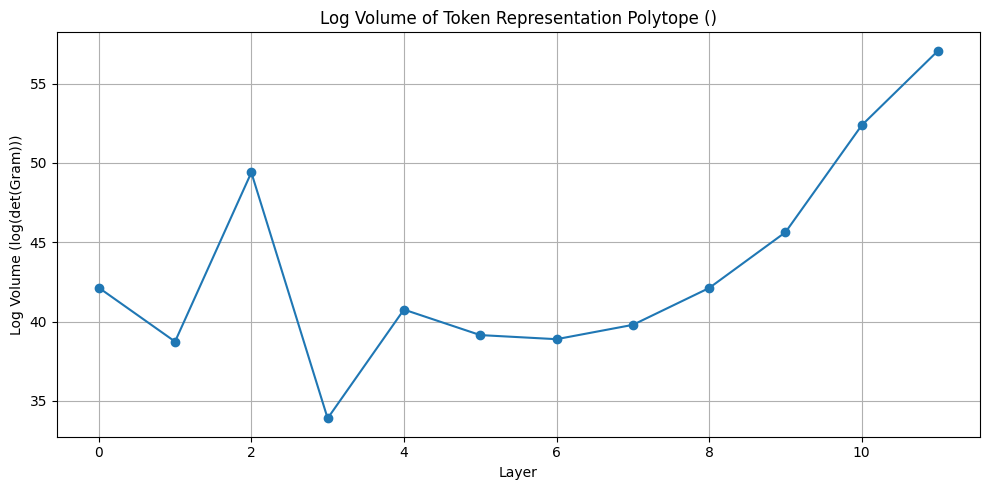

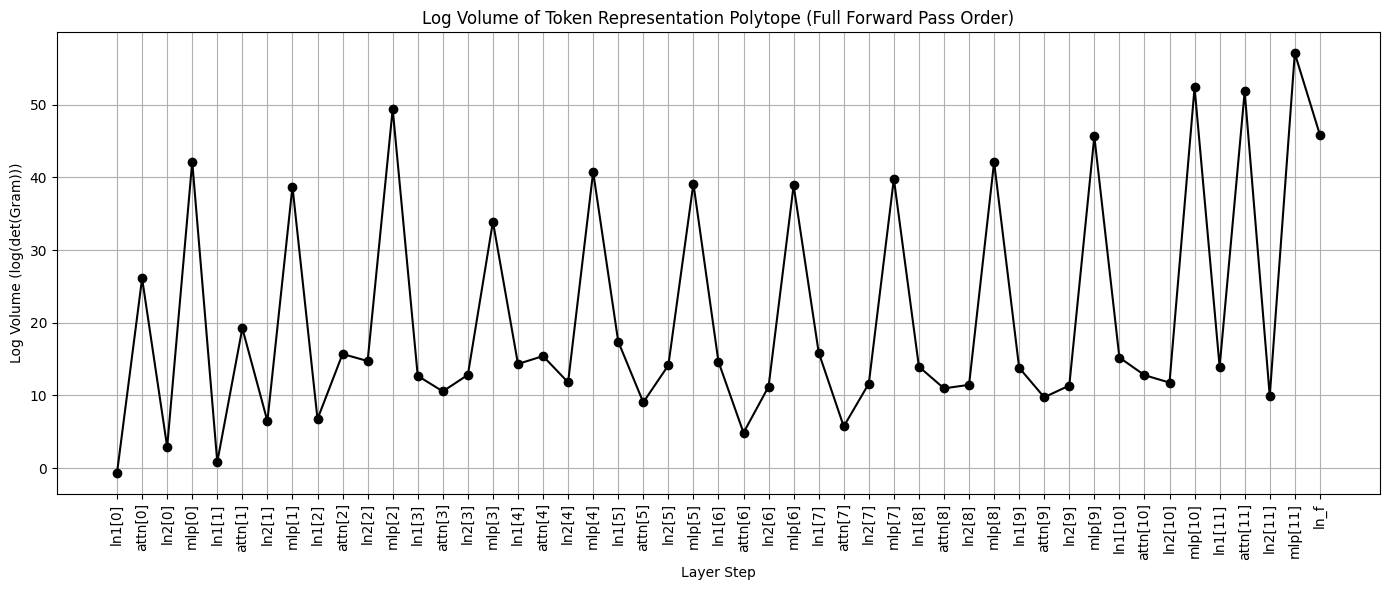

In [19]:
# Step 1: Compute all log volumes
ln1_log_vols = compute_log_volume(ln1_outputs, '')       # len = 13
attn_log_vols = compute_log_volume(attention_outputs, '')  # len = 12
ln2_log_vols = compute_log_volume(ln2_outputs, '')       # len = 12
mlp_log_vols = compute_log_volume(mlp_outputs, '')       # len = 12

# Step 2: Interleave them into a single list
all_log_vols = []
layer_labels = []

for i in range(12):  # 12 layers
    all_log_vols.append(ln1_log_vols[i])
    layer_labels.append(f"ln1[{i}]")

    all_log_vols.append(attn_log_vols[i])
    layer_labels.append(f"attn[{i}]")

    all_log_vols.append(ln2_log_vols[i])
    layer_labels.append(f"ln2[{i}]")

    all_log_vols.append(mlp_log_vols[i])
    layer_labels.append(f"mlp[{i}]")

# Add final ln1[12] (ln_f)
all_log_vols.append(ln1_log_vols[12])
layer_labels.append("ln_f")

# Step 3: Plot
plt.figure(figsize=(14, 6))
plt.plot(range(len(all_log_vols)), all_log_vols, marker='o', color='black')
plt.xticks(ticks=range(len(all_log_vols)), labels=layer_labels, rotation=90)
plt.title("Log Volume of Token Representation Polytope (Full Forward Pass Order)")
plt.xlabel("Layer Step")
plt.ylabel("Log Volume (log(det(Gram)))")
plt.grid(True)
plt.tight_layout()
plt.show()


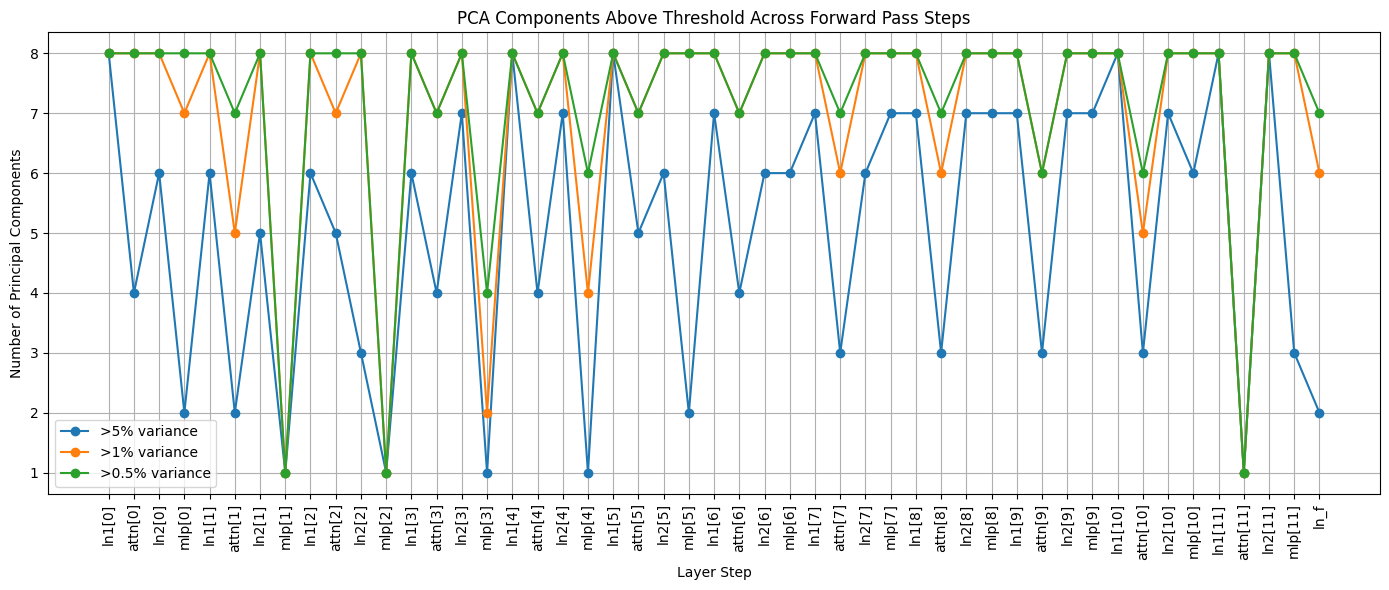

In [21]:
def compute_pca_components(outputs_list, thresholds=[0.01, 0.005, 0.001]):
    layerwise_counts = {thr: [] for thr in thresholds}

    for out in outputs_list:
        vecs = out[0].cpu().numpy()  # shape: [seq_len, hidden_dim]
        pca = PCA()
        pca.fit(vecs)
        explained = pca.explained_variance_ratio_

        for thr in thresholds:
            count = np.sum(explained > thr)
            layerwise_counts[thr].append(count)

    return layerwise_counts

thresholds = [0.05, 0.01, 0.005]
threshold_labels = [">5%", ">1%", ">0.5%"]

pca_ln1 = compute_pca_components(ln1_outputs, thresholds)
pca_attn = compute_pca_components(attention_outputs, thresholds)
pca_ln2 = compute_pca_components(ln2_outputs, thresholds)
pca_mlp = compute_pca_components(mlp_outputs, thresholds)

# Build stepwise interleaved sequence
interleaved_counts = {thr: [] for thr in thresholds}
labels = []

for i in range(12):  # GPT2 has 12 layers
    for thr in thresholds:
        interleaved_counts[thr].append(pca_ln1[thr][i])
    labels.append(f"ln1[{i}]")

    for thr in thresholds:
        interleaved_counts[thr].append(pca_attn[thr][i])
    labels.append(f"attn[{i}]")

    for thr in thresholds:
        interleaved_counts[thr].append(pca_ln2[thr][i])
    labels.append(f"ln2[{i}]")

    for thr in thresholds:
        interleaved_counts[thr].append(pca_mlp[thr][i])
    labels.append(f"mlp[{i}]")

# Add final ln_f
for thr in thresholds:
    interleaved_counts[thr].append(pca_ln1[thr][12])
labels.append("ln_f")

plt.figure(figsize=(14, 6))

for thr, label_str in zip(thresholds, threshold_labels):
    plt.plot(interleaved_counts[thr], marker='o', label=f'{label_str} variance')

plt.xticks(ticks=range(len(labels)), labels=labels, rotation=90)
plt.title("PCA Components Above Threshold Across Forward Pass Steps")
plt.xlabel("Layer Step")
plt.ylabel("Number of Principal Components")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Perform PCA across all vectors from outputs_list and the top 10 token embeddings.

Plot the trajectory of the last token's representation across layers.

Overlay the reduced embeddings of the top 10 tokens (e.g., "Ġrelativity", etc.)

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def plot_pca_trajectories(outputs_list, label, tokens, top_embeddings, top_tokens):
    n_layers = len(outputs_list)

    # 1. Get the last token's vector across layers
    last_token_vecs = np.stack([outputs_list[i][0, -1].cpu().numpy() for i in range(n_layers)])  # [n_layers, hidden_dim]

    # 2. Stack with top token embeddings for joint PCA
    all_vecs = np.vstack([last_token_vecs] + list(top_embeddings))  # shape: [n_layers + 10, hidden_dim]

    # 3. PCA to 2D
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(all_vecs)

    reduced_last = reduced[:n_layers]       # [n_layers, 2]
    reduced_top = reduced[n_layers:]        # [10, 2]

    # 4. Plot
    plt.figure(figsize=(8, 6))

    # Plot trajectory of last token
    x_last, y_last = zip(*reduced_last)
    plt.plot(x_last, y_last, marker='o', color='red', label=f'Last Token ("{tokens[-1]}")')
    for i, (x, y) in enumerate(reduced_last):
        plt.text(x + 0.01, y + 0.01, f'L{i}', fontsize=8, color='red')

    # Plot top token embeddings
    for i, (x, y) in enumerate(reduced_top):
        color = 'black' if i == 0 else plt.cm.plasma(i / len(top_tokens))  # Highlight first token
        plt.scatter(x, y, color=color, s=60, marker='x', label=top_tokens[i].strip() if i == 0 else None)
        plt.text(x + 0.01, y + 0.01, top_tokens[i].strip(), fontsize=8, color=color)

    plt.title(f"PCA Trajectory of Last Token + Top Token Embeddings: {label}")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.grid(True)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()


In [ ]:
plot_pca_trajectories(attention_outputs, "Attention Output", tokens, top_embeddings, top_tokens)
plot_pca_trajectories(mlp_outputs, "MLP Output", tokens, top_embeddings, top_tokens)
plot_pca_trajectories(ln1_outputs, "LN Output", tokens, top_embeddings, top_tokens)
